In [2]:
import numpy as np
import matplotlib.pyplot as plt

def minmod(a, b, c):
    """
    Minmod function for three arguments as per equation (12).
    """
    sgn_a = np.sign(a)
    sgn_b = np.sign(b)
    sgn_c = np.sign(c)
    min_abs = np.min([np.abs(a), np.abs(b), np.abs(c)])
    result = 0.25 * (sgn_a + sgn_b) * (sgn_a + sgn_c) * min_abs
    return result

def reconstruct(c, theta):
    """
    Reconstruct left and right states at cell interfaces using minmod limiter.
    """
    nx = len(c)
    c_L = np.zeros(nx + 1)  # Interfaces from 0 to nx
    c_R = np.zeros(nx + 1)
    sigma = np.zeros(nx)

    # Compute slopes
    for i in range(2, nx - 2):
        delta_c_minus = c[i] - c[i - 1]
        delta_c_plus = c[i + 1] - c[i]
        delta_c_center = 0.5 * (c[i + 1] - c[i - 1])
        sigma[i] = minmod(theta * delta_c_minus, delta_c_center, theta * delta_c_plus)

    # Reconstruct left and right states at interfaces
    for i in range(2, nx - 2):
        c_L[i] = c[i] + 0.5 * sigma[i]
        c_R[i] = c[i + 1] - 0.5 * sigma[i + 1]

    return c_L, c_R

def compute_flux(U, gamma):
    """
    Compute the flux vector F given conserved variables U.
    """
    rho = U[0]
    rho_v = U[1]
    E = U[2]
    v = rho_v / rho
    P = (gamma - 1) * (E - 0.5 * rho * v ** 2)
    F = np.zeros(3)
    F[0] = rho * v
    F[1] = rho * v ** 2 + P
    F[2] = (E + P) * v
    return F

def compute_hll_flux(U_L, U_R, gamma):
    """
    Compute HLL flux at an interface given left and right states.
    """
    rho_L = U_L[0]
    rho_R = U_R[0]
    v_L = U_L[1] / rho_L
    v_R = U_R[1] / rho_R
    E_L = U_L[2]
    E_R = U_R[2]
    P_L = (gamma - 1) * (E_L - 0.5 * rho_L * v_L ** 2)
    P_R = (gamma - 1) * (E_R - 0.5 * rho_R * v_R ** 2)

    # Apply pressure and density floors to prevent negative values
    P_L = max(P_L, 1e-6)
    P_R = max(P_R, 1e-6)
    rho_L = max(rho_L, 1e-6)
    rho_R = max(rho_R, 1e-6)

    c_L = np.sqrt(gamma * P_L / rho_L)
    c_R = np.sqrt(gamma * P_R / rho_R)

    S_L = min(v_L - c_L, v_R - c_R, 0.0)
    S_R = max(v_L + c_L, v_R + c_R, 0.0)

    if S_L >= 0:
        F_HLL = compute_flux(U_L, gamma)
    elif S_R <= 0:
        F_HLL = compute_flux(U_R, gamma)
    else:
        F_L = compute_flux(U_L, gamma)
        F_R = compute_flux(U_R, gamma)
        F_HLL = (S_R * F_L - S_L * F_R + S_L * S_R * (U_R - U_L)) / (S_R - S_L)
    return F_HLL

def compute_L(U, nx, dx, gamma, theta):
    """
    Compute the spatial derivative operator L(U).
    """
    L = np.zeros_like(U)
    rho = U[:, 0]
    rho_v = U[:, 1]
    E = U[:, 2]
    v = rho_v / rho
    P = (gamma - 1) * (E - 0.5 * rho * v ** 2)

    # Reconstruct variables
    rho_L, rho_R = reconstruct(rho, theta)
    v_L, v_R = reconstruct(v, theta)
    P_L, P_R = reconstruct(P, theta)

    U_L = np.zeros((nx + 1, 3))
    U_R = np.zeros((nx + 1, 3))
    F = np.zeros((nx + 1, 3))

    # Compute U_L and U_R at interfaces
    for i in range(2, nx - 2):
        U_L[i, 0] = rho_L[i]
        U_L[i, 1] = rho_L[i] * v_L[i]
        U_L[i, 2] = P_L[i] / (gamma - 1) + 0.5 * rho_L[i] * v_L[i] ** 2
        U_R[i, 0] = rho_R[i]
        U_R[i, 1] = rho_R[i] * v_R[i]
        U_R[i, 2] = P_R[i] / (gamma - 1) + 0.5 * rho_R[i] * v_R[i] ** 2

        # Compute HLL flux at interface
        F[i] = compute_hll_flux(U_L[i], U_R[i], gamma)

    # Compute L[i] = - (F[i] - F[i - 1]) / dx
    for i in range(3, nx - 3):
        L[i] = - (F[i] - F[i - 1]) / dx

    return L

def apply_boundary_conditions(U):
    """
    Apply boundary conditions to U.
    """
    # Reflective boundary conditions
    U[0, :] = U[3, :]
    U[1, :] = U[2, :]
    U[2, :] = U[2, :]
    U[-1, :] = U[-4, :]
    U[-2, :] = U[-3, :]
    U[-3, :] = U[-3, :]
    return U

def shu_osher(U, nx, dx, dt, gamma, theta):
    """
    Perform a time step using the Shu-Osher third-order scheme.
    """
    # Stage 1
    L1 = compute_L(U, nx, dx, gamma, theta)
    U1 = U + dt * L1
    U1 = apply_boundary_conditions(U1)

    # Stage 2
    L2 = compute_L(U1, nx, dx, gamma, theta)
    U2 = 0.75 * U + 0.25 * (U1 + dt * L2)
    U2 = apply_boundary_conditions(U2)

    # Stage 3
    L3 = compute_L(U2, nx, dx, gamma, theta)
    U_new = (1.0 / 3.0) * U + (2.0 / 3.0) * (U2 + dt * L3)
    U_new = apply_boundary_conditions(U_new)

    return U_new

def compute_time_step(U, dx, cfl, gamma):
    """
    Compute time step size dt based on CFL condition.
    """
    rho = U[:, 0]
    rho_v = U[:, 1]
    E = U[:, 2]
    v = rho_v / rho
    P = (gamma - 1) * (E - 0.5 * rho * v ** 2)

    # Apply pressure and density floors
    P = np.maximum(P, 1e-6)
    rho = np.maximum(rho, 1e-6)

    c_s = np.sqrt(gamma * P / rho)
    max_speed = np.max(np.abs(v) + c_s)
    dt = cfl * dx / max_speed
    return dt




In [8]:
def main():
    import time
    start_time = time.time()

    gamma = 1.4
    nx = 400
    x_start = 0.0
    x_end = 1.0
    dx = (x_end - x_start) / (nx - 1)
    x = np.linspace(x_start - 2 * dx, x_end + 2 * dx, nx + 4)  # Include ghost cells

    # Initialize variables
    rho = np.zeros(nx + 4)
    v = np.zeros(nx + 4)
    P = np.zeros(nx + 4)

    # Initial conditions for Sod shock tube
    rho_L = 10.0
    rho_R = 1.0
    P_L = 8.0
    P_R = 1.0
    v_L = 0.0
    v_R = 0.0

    # Physical domain without ghost cells
    x_physical = x[2:-2]
    rho[2:-2][x_physical <= 0.5] = rho_L
    rho[2:-2][x_physical > 0.5] = rho_R
    P[2:-2][x_physical <= 0.5] = P_L
    P[2:-2][x_physical > 0.5] = P_R
    v[2:-2][x_physical <= 0.5] = v_L
    v[2:-2][x_physical > 0.5] = v_R

    E = P / (gamma - 1) + 0.5 * rho * v ** 2
    rho_v = rho * v

    U = np.zeros((nx + 4, 3))
    U[:, 0] = rho
    U[:, 1] = rho_v
    U[:, 2] = E

    # Apply boundary conditions
    U = apply_boundary_conditions(U)

    # Time parameters
    t = 0.0
    t_final = 0.25
    cfl = 0.5
    theta = 1.5

    # Time evolution loop
    while t < t_final:
        dt = compute_time_step(U, dx, cfl, gamma)
        if t + dt > t_final:
            dt = t_final - t
        U = shu_osher(U, nx + 4, dx, dt, gamma, theta)
        t += dt
#         print(f"t = {t:.4f}, dt = {dt:.4e}")

    end_time = time.time()
    print(f"Simulation completed in {end_time - start_time:.2f} seconds.")

    # Extract variables for plotting
    rho = U[:, 0]
    rho_v = U[:, 1]
    E = U[:, 2]
    v = rho_v / rho
    P = (gamma - 1) * (E - 0.5 * rho * v ** 2)

    # Exclude ghost cells for plotting
    x_plot = x[2:-2]
    rho_plot = rho[2:-2]
    v_plot = v[2:-2]
    P_plot = P[2:-2]
    
    
    # Save simulation results
    np.savez('simulation_results.npz', x=x[2:-2], rho=rho[2:-2], v=v[2:-2], P=P[2:-2])
    
if __name__ == "__main__":
    main()


    

Simulation completed in 51.84 seconds.


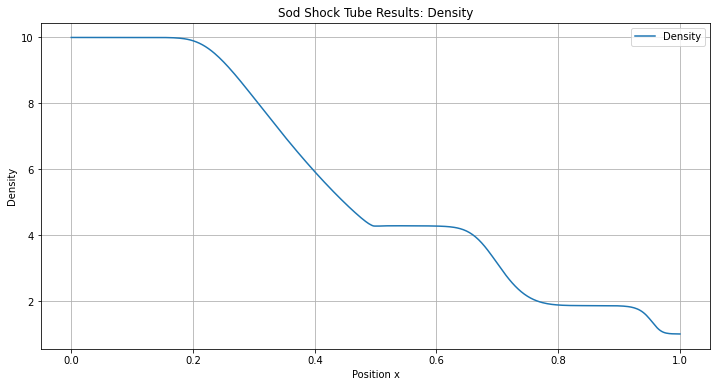

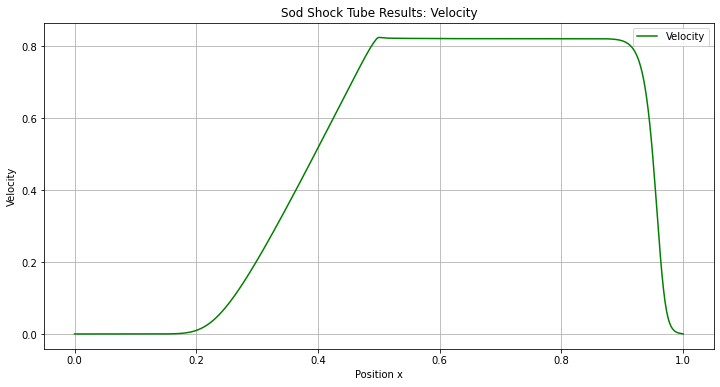

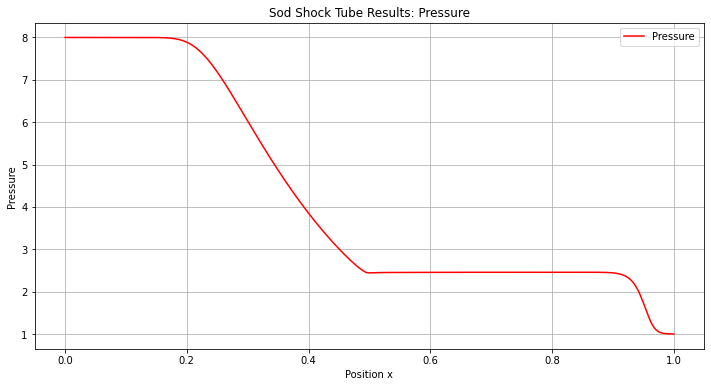

In [13]:
# Load simulation results
data = np.load('simulation_results.npz')
x_plot = data['x']
rho_plot = data['rho']
v_plot = data['v']
P_plot = data['P']

# Now proceed to plotting
# Plot Density
plt.figure(figsize=(12, 6))
plt.plot(x_plot, rho_plot, label='Density')
plt.title('Sod Shock Tube Results: Density')
plt.xlabel('Position x')
plt.ylabel('Density')
plt.legend()
plt.grid()
plt.savefig('shock_tube_density.png', dpi=300)
plt.show()

# Plot Velocity
plt.figure(figsize=(12, 6))
plt.plot(x_plot, v_plot, label='Velocity', color='green')
plt.title('Sod Shock Tube Results: Velocity')
plt.xlabel('Position x')
plt.ylabel('Velocity')
plt.legend()
plt.grid()
plt.savefig('shock_tube_velocity.png', dpi=300)
plt.show()

# Plot Pressure
plt.figure(figsize=(12, 6))
plt.plot(x_plot, P_plot, label='Pressure', color='red')
plt.title('Sod Shock Tube Results: Pressure')
plt.xlabel('Position x')
plt.ylabel('Pressure')
plt.legend()
plt.grid()
plt.savefig('shock_tube_pressure.png', dpi=300)
plt.show()

# Repeat similar blocks for Velocity and Pressure

